In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

import cv2
import hnswlib 
from PIL import Image

import tensorflow as tf

from unet import build_unet

## Helpers

In [2]:
class PerspectivePixelPermutator:
    """Remaps pixel locations based on a perspective permutation."""

    def __init__(self, w, h):
        self.w = int(w)
        self.h = int(h)

        self.X, self.Y = np.meshgrid(np.arange(w), np.arange(h))

    def get_index_permutation(self, 
        H,               #homography matrix of region 2 (used with cv2.warpPerspective)
        sub_xy,          #origin of second region rectangle
        frac_keep = 0.5, #fraction of pixels to align between the two regions
        ):

        H_inv = np.linalg.inv(H)
        l = 1/(H_inv[2,0]*self.X + H_inv[2,1]*self.Y + H_inv[2,2])
        X_ = (-H_inv[0,0]*H[0,2] - H_inv[0,1]*H[1,2] + H_inv[0,0]*self.X + H_inv[0,1]*self.Y)*l
        Y_ = (-H_inv[1,0]*H[0,2] - H_inv[1,1]*H[1,2] + H_inv[1,0]*self.X + H_inv[1,1]*self.Y)*l

        ind = np.round(np.stack([Y_.ravel(), X_.ravel()], axis=1)).astype(int)

        match = ((ind[:,1] > sub_xy[0])*(ind[:,1] < self.w + sub_xy[0])*(ind[:,0] > sub_xy[1])*(ind[:,0] < self.h + sub_xy[1])).reshape((-1,1))
        match *= np.random.random(match.shape) < frac_keep

        random_ind = np.stack([np.random.randint(0,self.h,self.w*self.h), np.random.randint(0,self.w,self.w*self.h)], axis=1)
        ind = match*(ind - [sub_xy[::-1]]) + (1 -  match)*random_ind

        ind_flat = ind[:,0]*self.w + ind[:,1]
        return ind_flat, match.ravel()

In [3]:
def get_motion_kernel(L_min=4, L_max=33, s_min=1, s_max=11):
    """Generates random motion blur kernel to be convolved with images."""

    L = np.random.randint(L_min, L_max)
    x = np.cumsum(np.cumsum(np.random.normal(0,1,L)))
    y = np.cumsum(np.cumsum(np.random.normal(0,1,L)))

    x -= np.min(x)
    y -= np.min(y)
    wf = int(np.max(x)) + 1
    hf = int(np.max(y)) + 1

    sigma = np.random.randint(s_min,s_max)
    F = np.zeros((hf+10*sigma, wf+10*sigma))

    F[y.astype(int)+5*sigma, x.astype(int)+5*sigma] = 1
    
    K = cv2.resize(scipy.ndimage.gaussian_filter(F, sigma), dsize = (0, 0), fx = 0.1, fy=0.1)

    X,Y = np.meshgrid(np.arange(K.shape[1]), np.arange(K.shape[0]))
    cx = np.sum(K*X)/np.sum(K)
    cy = np.sum(K*Y)/np.sum(K)

    py = int(np.round(K.shape[0]/2 - cy))
    px = int(np.round(K.shape[1]/2 - cx))

    return np.pad(K, ((max(0,py),max(0,-py)), (max(0,px),max(0,-px))))/np.sum(K)

## Image transforamtion example

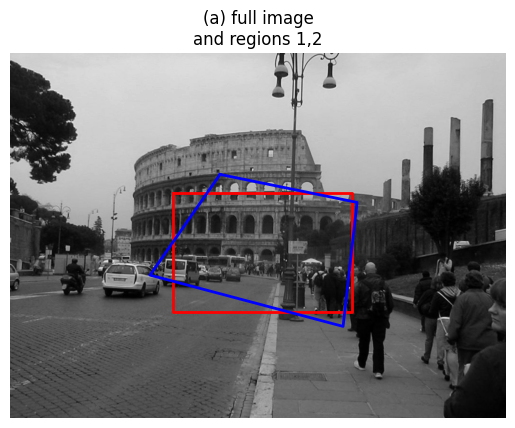

In [4]:
# An image from Image Matching Challenge 2022
im = np.mean(Image.open("img/74755671_121926671.jpg"), axis=2)/255

plt.title("(a) full image\nand regions 1,2")
plt.imshow(im, cmap="gray")
plt.axis("off")

w, h = 384, 256
sub_xy = [350, 300]

plt.plot([sub_xy[0],sub_xy[0]+w,sub_xy[0]+w,sub_xy[0],sub_xy[0]], [sub_xy[1],sub_xy[1],sub_xy[1]+h,sub_xy[1]+h,sub_xy[1]], color="r", linewidth=2)

# Points to mark the corners of two regions
pxs = np.array([100,10,-20,-50]) + [0,w,w,0] + sub_xy[0]
pys = np.array([-40,20,30,-80]) + [0,0,h,h] + sub_xy[1]

plt.plot(list(pxs) + [pxs[0]], list(pys) + [pys[0]], color="b", linewidth=2)

Text(0.5, 1.0, '(b) region 1\nwith motion blur')

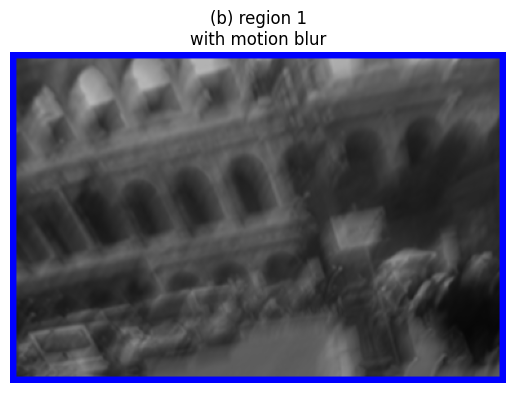

In [6]:
# Find a homography to map the non-rectangular region to a rectangle
src_points = np.stack([pxs, pys], axis=1).astype(np.float32)
dst_points = np.stack([[0,w,w,0], [0,0,h,h]], axis=1).astype(np.float32)

H, _ = cv2.findHomography(src_points, dst_points, 0)
region_1 = cv2.warpPerspective(im, H, (w, h), cv2.INTER_AREA)

np.random.seed(11)
K = get_motion_kernel()

region_1 = cv2.filter2D(region_1, -1, K)
region_1_c = np.stack([region_1]*3, axis=2)

region_1_c[:,:5] = region_1_c[:,-5:] = [0,0,1] #add cosmetic border
region_1_c[:5,:] = region_1_c[-5:,:] = [0,0,1]

plt.imshow(region_1_c)
plt.axis("off")
plt.title("(b) region 1\nwith motion blur")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '(c) region 2\nwith intensity noise')

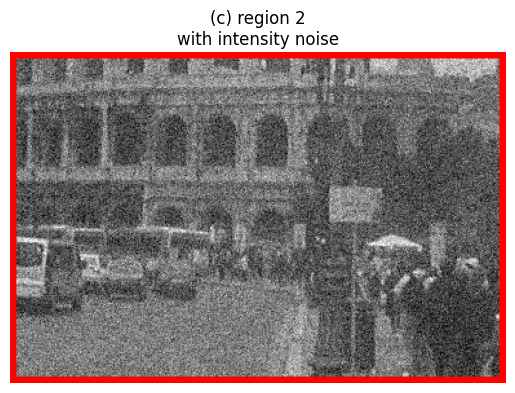

In [7]:
region_2 = im[sub_xy[1]:sub_xy[1]+h,sub_xy[0]:sub_xy[0]+w]*0.8 + np.random.normal(0.2, 0.1, (h,w))
region_2_c = np.stack([region_2]*3, axis=2)

region_2_c[:,:5] = region_2_c[:,-5:] = [1,0,0] #add cosmetic border
region_2_c[:5,:] = region_2_c[-5:,:] = [1,0,0]

plt.imshow(region_2_c)
plt.axis("off")
plt.title("(c) region 2\nwith intensity noise")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 383.5, 255.5, -0.5)

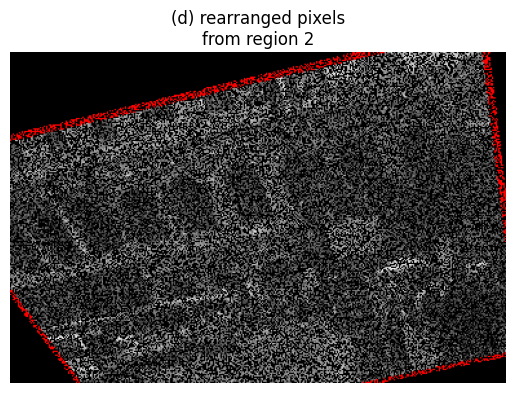

In [8]:
#This is similar to the cv2.warpPerspectve but done by remapping pixel indices so they can be selected
pp = PerspectivePixelPermutator(w,h)
inds, flags = pp.get_index_permutation(H, sub_xy, frac_keep = 0.5)

plt.imshow((region_2_c.reshape((w*h,-1))[inds]*flags[:,None]).reshape((h,w,-1)))
plt.title("(d) rearranged pixels\nfrom region 2")
plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 383.5, 255.5, -0.5)

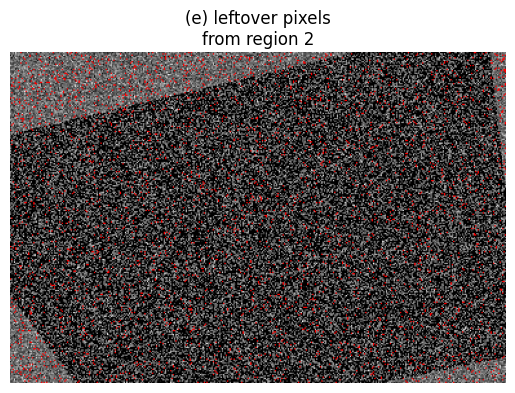

In [9]:
plt.imshow((region_2_c.reshape((w*h,-1))[inds]*(1-flags)[:,None]).reshape((h,w,-1)))
plt.title("(e) leftover pixels\nfrom region 2")
plt.axis("off")

## Feature Extraction via U-Net

The following creates a basic U-Net architecture to serve as the backbone feature extractor and loads pre-trained weights. See `unet.py` for network details.

In [1]:
# Create large UNet model
model = build_unet(
    height=h,
    width=w,
    depth=5,
    final_channels=32,
    num_res_blocks=3,
    norm_groups=8,
    first_conv_channels=8,  
)

# Model checkpoint needs to be downloaded separately (see checkpoint.md)
model.load_weights("tutorial_checkpoint/tutorial_checkpoint.weights.h5")

# Print out parameters
model.summary()

2024-10-09 13:39:01.135105: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


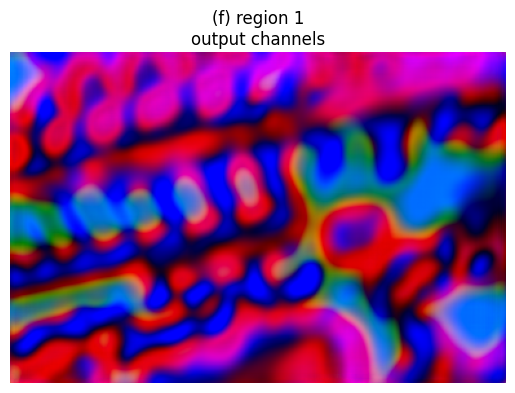

In [12]:
features = model(np.stack([region_1[:,:,None], region_2[:,:,None]], axis=0)).numpy()
channels = features.shape[-1]
features_c = features[:,:,:,16:19] + 0.5 #only show some of the representative channels in RGB
plt.title("(f) region 1\noutput channels")
plt.axis("off")
plt.imshow(features_c[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


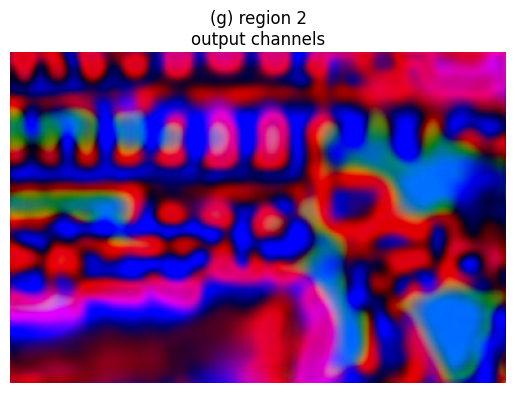

In [13]:
plt.title("(g) region 2\noutput channels")
plt.axis("off")
plt.imshow(features_c[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 383.5, 255.5, -0.5)

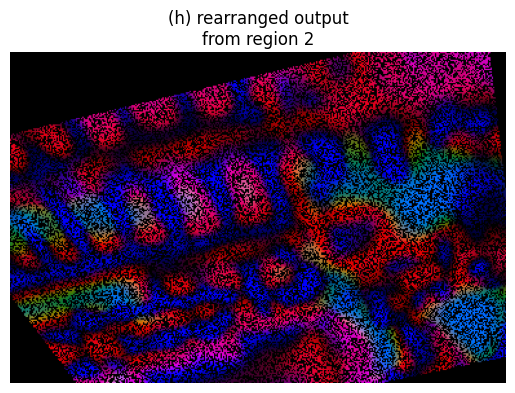

In [14]:
plt.imshow((features_c[1].reshape((w*h,-1))[inds]*flags[:,None]).reshape((h,w,-1)))
plt.title("(h) rearranged output\nfrom region 2")
plt.axis("off")

## Loss Function
The below code implements our custom contrastive loss function for overcomplete pixels. We are not actually using the loss in this notebook, as the network has already been trained.

In [15]:
def loss_fun(z, y):
    """Computes our custom contrastive loss (Eq. 3 in https://arxiv.org/abs/2410.07410)

    Parameters:
    -----------

    z : tf.Tensor or np.ndarray of shape (2*batch size, num_pixels)
        Contains the indices of the perspective permutation as well as the flags for which 
        pixels are being accurately/randomly remapped
    y : tf.Tensor or np.ndarray of shape (2*batch_size, height, width, num_output_channels)
        The output features of the network (i.e., overcomplete pixels)

    Returns:
    -------

    loss : tf.Tensor of shape (1,)
        The computed loss over the batch of images
    """

    loss = 0.
    batch_size = len(z)
    for i in range(batch_size//2):
        indices = tf.cast(z[2*i], tf.int32)
        flags = tf.cast(z[2*i+1], tf.float32)

        #Compute the pixels-wise maximum difference across all channels
        diff = tf.gather(tf.reshape(y[i*2+1], (w*h,-1)), indices, axis=0) - tf.reshape(y[i*2], (w*h,-1))
        max_diff = 0.5*tf.reduce_max(tf.abs(diff), axis=1)

        #Difference should be small if pixels are a "correct" match
        loss += 0.25*(1 - tf.reduce_mean(flags)) + tf.reduce_mean(max_diff*(2*flags - 1) + tf.square(max_diff))

    return loss

print(loss_fun([inds, flags], features))

tf.Tensor(0.120172754, shape=(), dtype=float32)


## Image alignment

(-0.5, 803.5, 551.5, -0.5)

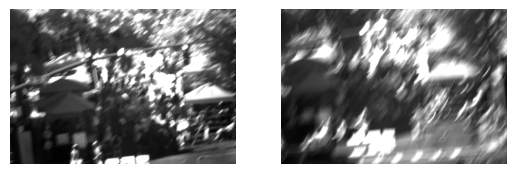

In [16]:
im_1 = np.load("frames/video_10_frame_0000.npy")
im_2 = np.load("frames/video_10_frame_0685.npy")
plt.subplot(121)
plt.imshow(im_1, cmap="gray")
plt.axis("off")
plt.subplot(122)
plt.imshow(im_2, cmap="gray")
plt.axis("off")

In [17]:
H,W = im_1.shape[:2]

# Splitting the image into parts to be processed by the network
x_grid = np.linspace(0,W-w,int(np.ceil(W/w))).astype(int)
y_grid = np.linspace(0,H-h,int(np.ceil(H/h))).astype(int)

# Using weighted average for network output in overlapping regions
X,Y = np.meshgrid(np.arange(w), np.arange(h))
pixel_weights = 1 + 1/max(w,h) - np.max([np.abs(X-w/2)/(w/2),np.abs(Y-h/2)/(h/2)], axis=0)

def process_image(im):
    sum_weights = np.zeros((H,W))
    features = np.zeros((H,W,channels))

    for y in y_grid:
        for x in x_grid:
            features[y:y+h,x:x+w] += model(im[None,y:y+h,x:x+w,None]).numpy()[0]*pixel_weights[:,:,None]
            sum_weights[y:y+h,x:x+w] += pixel_weights

    return features/sum_weights[:,:,None]

In [18]:
features_1 = process_image(im_1)
features_2 = process_image(im_2)

In [20]:
# Using the hnswlib graph to find the closest matches between images relaively fast
ids = np.arange(W*H)

tree_2 = hnswlib.Index(space = 'l2', dim = channels)
tree_2.init_index(2*W*H)
tree_2.add_items(features_2.reshape((-1,channels)), ids)

In [23]:
# Standard RANSAC to find the affine transformation between the two images
reprojection_threshold = 10

labels, distances = tree_2.knn_query(features_1.reshape((-1,channels)), k = 1)

dst_ids = ids
src_ids = labels.ravel()
dst_pts = np.stack([dst_ids%W, dst_ids//W], axis=1).reshape((-1,1,2)).astype(np.float32)
src_pts = np.stack([src_ids%W, src_ids//W], axis=1).reshape((-1,1,2)).astype(np.float32)

M, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts, ransacReprojThreshold=reprojection_threshold)

matches_1 = dst_pts[np.where(mask[:,0])[0]][:,0]
matches_2 = src_pts[np.where(mask[:,0])[0]][:,0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


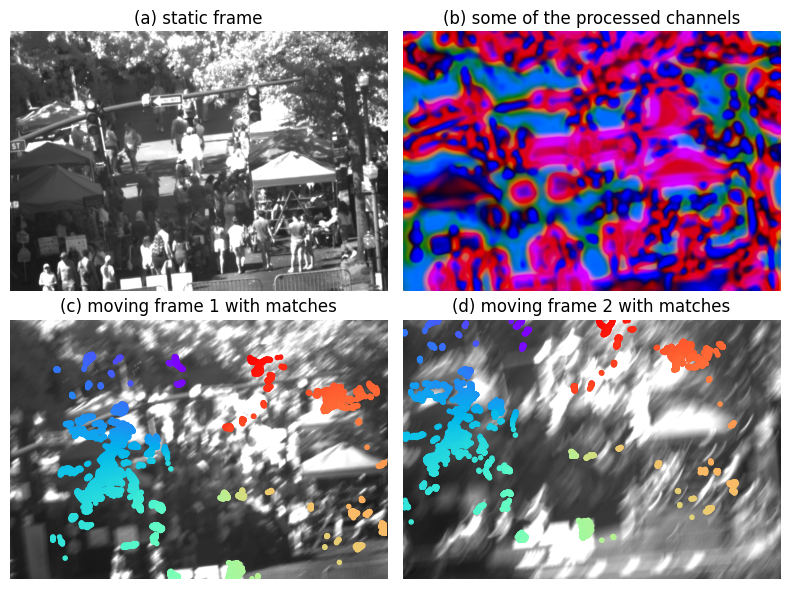

In [25]:
# Load and display the static frame
plt.figure(figsize=(8, 6))

# Subplot (a): Static frame
plt.subplot(2, 2, 1)
im = np.load("frames/video_06_frame_0000.npy")
plt.imshow(im, cmap="gray", vmin=0, vmax=1)
plt.axis("off")
plt.title("(a) Static Frame")

# Subplot (b): Processed channels
plt.subplot(2, 2, 2)
features = process_image(im)
plt.imshow(features[:, :, 16:19] + 0.5)
plt.axis("off")
plt.title("(b) Some of the Processed Channels")

# Subplot (c): Moving frame 1 with matches
ax3 = plt.subplot(2, 2, 3)
plt.imshow(im_1, cmap="gray", vmin=0, vmax=1)
c = np.arctan2(matches_1[:, 0] - W // 2, matches_1[:, 1] - H // 2)
plt.scatter(matches_1[:, 0], matches_1[:, 1], marker=".", c=c, cmap="rainbow")
plt.axis("off")
plt.title("(c) Moving Frame 1 with Matches")

# Subplot (d): Moving frame 2 with matches
ax4 = plt.subplot(2, 2, 4)
plt.imshow(im_2, cmap="gray", vmin=0, vmax=1)
plt.scatter(matches_2[:, 0], matches_2[:, 1], marker=".", c=c, cmap="rainbow")
plt.axis("off")
plt.title("(d) Moving Frame 2 with Matches")

# Adjust layout
plt.tight_layout()
plt.show()